In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import tensorflow as tf
import keras
import PIL
import scipy
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.initializers import *
from keras.backend import *

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def Load_Data():
  
  train_dataset = h5py.File('train_happy.h5','r')
  test_dataset = h5py.File('test_happy.h5','r')
  
  train_set_X_orig = np.array(train_dataset['train_set_x'][:])
  train_set_Y_orig = np.array(train_dataset['train_set_y'][:])
  test_set_X_orig = np.array(test_dataset['test_set_x'][:])
  test_set_Y_orig = np.array(test_dataset['test_set_y'][:])
  
  classes = np.array(test_dataset['list_classes'][:])
  
  return train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes

(600, 64, 64, 3) (600,) (150, 64, 64, 3) (150,)
It is Image_5 and the person is Happy.


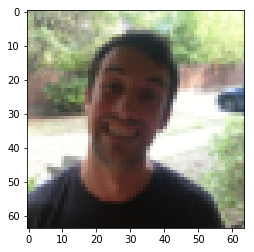

In [6]:
train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()
print(train_set_X_orig.shape,train_set_Y_orig.shape,test_set_X_orig.shape,test_set_Y_orig.shape)
i = 5
plt.imshow(train_set_X_orig[i])
print('It is Image_'+str(i)+' and the person is','Happy.' if classes[test_set_Y_orig[i]] else 'not Happy.')

In [0]:
def Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig):
 
  train_set_X = train_set_X_orig/255
  train_set_Y = train_set_Y_orig.reshape((train_set_Y_orig.shape[0],1))
  test_set_X = test_set_X_orig/255
  test_set_Y = test_set_Y_orig.reshape((test_set_Y_orig.shape[0],1))
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Read_Outputs():
  
  ptr = open('outputs_siamese.txt','r')
  data = ptr.readlines()

  train_Y = [float(c.strip()) for c in data]
  train_Y = np.array(train_Y)
  train_Y = train_Y.reshape((train_Y.shape[0],1))
  
  return train_Y

In [0]:
def Create_Database():
  
  database = {}
  database["younes"] = "images/younes.jpg"
  database["tian"] = "images/tian.jpg"
  database["andrew"] = "images/andrew.jpg"
  database["kian"] = "images/kian.jpg"
  database["dan"] = "images/dan.jpg"
  database["sebastiano"] = "images/sebastiano.jpg"
  database["bertrand"] = "images/bertrand.jpg"
  database["kevin"] = "images/kevin.jpg"
  database["felix"] = "images/felix.jpg"
  database["benoit"] = "images/benoit.jpg"
  database["arnaud"] = "images/arnaud.jpg"
  
  return database

In [0]:
def Data_Preprocessing():

  train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()
  train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig)
  
  data = train_set_X_orig[0:21,:,:,:]
  temp = np.zeros((1,64,64,3))
  temp[0,:,:,:] = data[1,:,:,:]
  data[1,:,:,:] = data[2,:,:,:]
  data[2,:,:,:] = temp[0,:,:,:]
  temp[0,:,:,:] = data[15,:,:,:]
  data[15,:,:,:] = data[19,:,:,:]
  data[19,:,:,:] = temp[0,:,:,:]
  temp[0,:,:,:] = data[16,:,:,:]
  data[16,:,:,:] = data[17,:,:,:]
  data[17,:,:,:] = temp[0,:,:,:]
  
  train_X1 = data[0:20,:,:,:]
  train_X2 = data[1:21,:,:,:]
  
  train_Y = Read_Outputs()
  database = Create_Database()
  
  return train_X1,train_X2,train_Y,database

In [0]:
def Inception_Block(X,channels,layers,XorY):
  
  X_3x3 = Conv2D(channels[0],kernel_size=(1,1),strides=(1,1),padding='valid',name="Inception_Block"+str(layers)+"_Conv2D_1x1A"+XorY)(X)
  X_3x3 = BatchNormalization(axis=3,name='Inception_Block'+str(layers)+'_BatchNorm_1'+XorY)(X_3x3)
  X_3x3 = Activation('relu')(X_3x3)
  X_3x3 = ZeroPadding2D((1,1))(X_3x3)
  X_3x3 = Conv2D(channels[1],kernel_size=(3,3),strides=(1,1),padding='valid',name='Inception_Block'+str(layers)+'_Conv2D_3x3'+XorY)(X_3x3)
  X_3x3 = BatchNormalization(axis=3,name='Inception_Block'+str(layers)+'_BatchNorm_2'+XorY)(X_3x3)
  X_3x3 = Activation('relu')(X_3x3)
  
  
  X_5x5 = Conv2D(channels[2],kernel_size=(1,1),strides=(1,1),padding='valid',name="Inception_Block"+str(layers)+"_Conv2D_1x1B"+XorY)(X)
  X_5x5 = BatchNormalization(axis=3,name='Inception_Block'+str(layers)+'_BatchNorm_3'+XorY)(X_5x5)
  X_5x5 = Activation('relu')(X_5x5)
  X_5x5 = ZeroPadding2D((2,2))(X_5x5)
  X_5x5 = Conv2D(channels[3],kernel_size=(5,5),strides=(1,1),padding='valid',name='Inception_Block'+str(layers)+'_Conv2D_5x5'+XorY)(X_5x5)
  X_5x5 = BatchNormalization(axis=3,name='Inception_Block'+str(layers)+'_BatchNorm_4'+XorY)(X_5x5)
  X_5x5 = Activation('relu')(X_5x5)
  

  X_Pool = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same',name='Inception_Block'+str(layers)+'_MaxPool'+XorY)(X)
  X_Pool = Conv2D(channels[4],kernel_size=(1,1),strides=(1,1),padding='valid',name='Inception_Block'+str(layers)+'_Conv2D_1x1C'+XorY)(X_Pool)
  X_Pool = BatchNormalization(axis=3,name="Inception_Block"+str(layers)+"_BatchNorm_6"+XorY)(X_Pool)
  X_Pool = Activation('relu')(X_Pool)
  
  
  X_1x1 = Conv2D(channels[5],kernel_size=(1,1),strides=(1,1),padding='valid',name='Inception_Block'+str(layers)+'_Conv2D_1x1D'+XorY)(X)
  X_1x1 = BatchNormalization(axis=3,name='Inception_Block'+str(layers)+'_BatchNorm_5'+XorY)(X_1x1)
  X_1x1 = Activation('relu')(X_1x1)
  
  inception = Concatenate(axis=3)([X_3x3,X_5x5,X_Pool,X_1x1])
  
  return inception

In [0]:
def Propagation(input_shape,output_neurons,channel_list):
  
  X_input = Input(input_shape)
  X = X_input
  
  X = ZeroPadding2D((3,3))(X)
  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform',name='Normal_Block_Conv2D_X')(X)
  X = BatchNormalization(axis=3,name='Normal_Block_BatchNorm_X')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name='Normal_Block_MaxPool1_X')(X)
  
  '''X = Inception_Block(X,channel_list[0],1,'X')
  X = Inception_Block(X,channel_list[1],2,'X')
  X = Inception_Block(X,channel_list[2],3,'X')
  
  X = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name="Normal_Block_MaxPool2_X")(X)
  X = Inception_Block(X,channel_list[3],4,'X')
  X = Inception_Block(X,channel_list[4],5,'X')
  
  X = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name="Normal_Block_MaxPool3_X")(X)
  X = Inception_Block(X,channel_list[5],6,'X')
  X = Inception_Block(X,channel_list[6],7,'X')'''
  
  X = AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name='Normal_Block_AveragePool_X')(X)
  X = Flatten()(X)
  
  if(output_neurons > 1):
    activation = 'softmax'
  else:
    activation = 'sigmoid'
  X = Dense(output_neurons,activation=activation,kernel_initializer='glorot_uniform',bias_initializer='zeros',name='Normal_Layer_FullyConnected_X',use_bias=True)(X)
  
  
  Y_input = Input(input_shape)
  Y = Y_input
  
  Y = ZeroPadding2D((3,3))(Y)
  Y = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='valid',kernel_initializer='glorot_uniform',name='Normal_Block_Conv2D_Y')(Y)
  Y = BatchNormalization(axis=3,name='Normal_Block_BatchNorm_Y')(Y)
  Y = Activation('relu')(Y)
  Y = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name='Normal_Block_MaxPool1_Y')(Y)
  
  '''Y = Inception_Block(Y,channel_list[0],1,'Y')
  Y = Inception_Block(Y,channel_list[1],2,'Y')
  Y = Inception_Block(Y,channel_list[2],3,'Y')
  
  Y = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name="Normal_Block_MaxPool2_Y")(Y)
  Y = Inception_Block(Y,channel_list[3],4,'Y')
  Y = Inception_Block(Y,channel_list[4],5,'Y')
  
  Y = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name="Normal_Block_MaxPool3_Y")(Y)
  Y = Inception_Block(Y,channel_list[5],6,'Y')
  Y = Inception_Block(Y,channel_list[6],7,'Y')'''
  
  Y = AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid',name='Normal_Block_AveragePool_Y')(Y)
  Y = Flatten()(Y)
  
  if(output_neurons > 1):
    activation = 'softmax'
  else:
    activation = 'sigmoid'

  Y = Dense(output_neurons,activation=activation,kernel_initializer='glorot_uniform',bias_initializer='zeros',name='Normal_Layer_FullyConnected_Y',use_bias=True)(Y)
  
  A = Subtract()([X,Y])
  A = Dense(50,activation='softmax',kernel_initializer='glorot_uniform', bias_initializer='zeros')(A)
  A = Dense(1,activation='sigmoid',name="Siamese_Last_Layer",kernel_initializer='glorot_uniform', bias_initializer='zeros')(A)
  model = Model(inputs=[X_input,Y_input],outputs=A,name='Siamese_Keras_InceptionModel')
  
  return model

In [0]:
def Read_Image(image_path):
  
  import skimage
  
  image = plt.imread(image_path)
  image = skimage.transform.resize(image,(64,64))
  image = np.expand_dims(image,axis=0)
  
  return image

In [0]:
def Reshape_And_Normalize_Happy(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig):
  
  m_train = train_set_X_orig.shape[0]
  m_test = test_set_X_orig.shape[0]
  train_set_X = train_set_X_orig.reshape(m_train,-1)
  test_set_X = test_set_X_orig.reshape(m_test,-1)

  train_set_Y = train_set_Y_orig.reshape((m_train,1))
  test_set_Y = test_set_Y_orig.reshape((m_test,1))
  
  U_train = np.sum(train_set_X,axis=1,keepdims=True)/m_train
  U_test = np.sum(test_set_X,axis=1,keepdims=True)/m_test
  
  train_set_X = train_set_X - U_train
  test_set_X = test_set_X - U_test
  
  sigma_train = np.sqrt(np.sum(np.square(train_set_X),axis=1,keepdims=True)/m_train)
  sigma_test = np.sqrt(np.sum(np.square(test_set_X),axis=1,keepdims=True)/m_test)
  
  train_set_X /= sigma_train
  test_set_X /= sigma_test
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Data_Preprocessing_Happy():
  
  train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes = Load_Data()
  train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize_Happy(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig)
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Propagation_Happy(input_shape,output_neurons):
  
  X_input = Input(input_shape)
  X = X_input
  
  if(output_neurons > 1):
    activation_type = 'softmax'
  elif(output_neurons == 1):
    activation_type = 'sigmoid'
  
  X = BatchNormalization(axis=1,name='BatchNormalization')(X)
  X = Dense(output_neurons,use_bias=True,activation=activation_type,kernel_initializer='glorot_uniform', bias_initializer='zeros',name='FullyConnected',kernel_regularizer=regularizers.l2(0.01))(X)
  
  model = keras.models.Model(inputs=X_input,outputs=X,name="ANN_Keras")
  
  return model

In [0]:
def Caller_Function_Happy():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y = Data_Preprocessing_Happy()
  epochs = 10
  mini_batch_size = 50
  output_neurons = 1
  
  if(output_neurons > 1):
    train_set_Y = np.eye(output_neurons)[train_set_Y.T][0]
    test_set_Y = np.eye(output_neurons)[test_set_Y.T][0]
    loss_val = 'categorical_crossentropy'
  elif(output_neurons == 1):
    loss_val = 'binary_crossentropy'
    
  input_shape = [train_set_X.shape[1]]
 
  model = Propagation_Happy(input_shape,output_neurons)
  model.compile(loss=loss_val,optimizer='adam',metrics=['accuracy'])
  print("\n---------------------------------------------Happy House Start-------------------------------------------\n")
  model.fit(x=train_set_X[0:50,:],y=train_set_Y[0:50,:],epochs=epochs,batch_size=mini_batch_size)
  
  return model

In [0]:
def Caller_Function():
  
  model_happy = Caller_Function_Happy()
  train_X1,train_X2,train_Y,database = Data_Preprocessing()
  epochs = 5
  mini_batch_size = 2
  output_neurons = 128
  
  shape = train_X1.shape
  shape = (shape[1],shape[2],shape[3])
 
  channel_list = [[96,128,16,32,32,64],[96,128,32,64,64,64],[128,256,32,64,16,32],[96,192,32,64,128,256],[160,256,64,128,32,64],[96,128,64,128,192,256],[192,512,128,256,512,512]]
  model = Propagation(shape,output_neurons,channel_list)
  opt = Adam(lr=0.5)
  model.compile(loss='mean_squared_error',optimizer=opt,metrics=['accuracy'])
  print("\n---------------------------------------------Siamese Start-------------------------------------------\n")
  model.fit(x=[train_X1,train_X2],y=train_Y,epochs=epochs,batch_size=mini_batch_size)
  
  return model_happy,model,database,train_X1

  #model.summary()

In [147]:
model_happy,model,database,train_X1 = Caller_Function()


---------------------------------------------Happy House Start-------------------------------------------

Epoch 1/10
50/50 [==============================] - 27s 536ms/step - loss: 0.7147 - acc: 0.5800
Epoch 2/10
50/50 [==============================] - 0s 775us/step - loss: 0.6406 - acc: 0.7000
Epoch 3/10
50/50 [==============================] - 0s 791us/step - loss: 0.5814 - acc: 0.6800
Epoch 4/10
50/50 [==============================] - 0s 703us/step - loss: 0.5343 - acc: 0.7200
Epoch 5/10
50/50 [==============================] - 0s 746us/step - loss: 0.4937 - acc: 0.7200
Epoch 6/10
50/50 [==============================] - 0s 722us/step - loss: 0.4578 - acc: 0.7400
Epoch 7/10
50/50 [==============================] - 0s 887us/step - loss: 0.4263 - acc: 0.8600
Epoch 8/10
50/50 [==============================] - 0s 752us/step - loss: 0.3988 - acc: 0.8600
Epoch 9/10
50/50 [==============================] - 0s 839us/step - loss: 0.3738 - acc: 0.9200
Epoch 10/10
50/50 [=================

In [0]:
def evaluate(model_happy,model,database,train_X1):
  print('')
  name = 'arnaud'
  model_type = "verification"
  if(model_type == 'verification'):
    image_path = database[name]
    anchor = Read_Image(image_path)
    i = 10
    person = np.zeros((1,64,64,3))
    person[0,:,:,:] = train_X1[i,:,:,:]
    out = model.predict(x=[anchor,person])
    if(out[0][0] >= 0.4):
      print('Same',out)
      img = person.reshape((person.shape[0],-1))
      ans = np.ceil(model_happy.predict(img))
      print('Allowed' if ans else 'Rejected')
    else:
      print('Different',out)
  
  else:
    mx = -100.0
    i = 5
    person = np.zeros((1,64,64,3))
    person[0,:,:,:] = train_X1[i,:,:,:]
    
    for names in database:
      image_path = database[names]
      anchor = Read_Image(image_path)
      out = model.predict(x=[anchor,person])
      if(out[0][0] > mx):
        mx = out[0][0]
        person_name = names

    if(mx >= 0.4):
      print('Hello '+person_name)
      img = person.reshape((person.shape[0],-1))
      ans = np.ceil(model_happy.predict(img))
      print('Allowed' if ans else 'Rejected')
    else:
      print('Not in Database')
      

In [153]:
evaluate(model_happy,model,database,train_X1)


Different [[0.37951922]]


In [137]:
model_happy.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 12288)             0         
_________________________________________________________________
BatchNormalization (BatchNor (None, 12288)             49152     
_________________________________________________________________
FullyConnected (Dense)       (None, 1)                 12289     
Total params: 61,441
Trainable params: 36,865
Non-trainable params: 24,576
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
i